In [8]:
%load_ext autoreload
%autoreload 2

### Triplet Loss

We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.


<img src="./images/triplet.png" height="422" width="722" >

Triplet loss is given by the following :-

$$ \mathcal{L}(I_{1}, I_{2}, I_{3}) = ReLU\{m + (\mathcal{E}_{I_{1}} - \mathcal{E}_{I_{2}})^{2} - (\mathcal{E}_{I_{1}} - \mathcal{E}_{I_{3}})^{2} \}$$

where $\mathcal{E}$ is the final layer embedding of the neural network, $\mathcal{I_{1}}$ is the example from primary domain, $\mathcal{I_{2}}$ is the example from helper domain.  

In [23]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# tNSE embeddings from the penultimate layer of LeNet
from sklearn.manifold import TSNE

In [10]:
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset

# Set up data loaders
from datasets import TripletCD

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet, TripletNet, LeNet
from losses import ContrastiveLoss, TripletLoss

classes = [i for i in range(10)]
instances = [5000 for i in range(10)]


batch_size=128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

In [11]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('SVHN', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('SVHN', classes, instances, 'test' )


primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

triplet_train_dataset=TripletCD(train_dataset_primary, train_dataset_helper)
triplet_test_dataset=TripletCD(test_dataset_primary, test_dataset_helper)

triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [21]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(primary_embeddings, primary_targets, helper_embeddings, helper_targets):
    
    plt.figure(figsize=(10,10))
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

    for i in range(10):
        primary_inds = np.where(primary_targets==i)[0]
        primary_tsne = tsne.fit_transform(primary_embeddings[primary_inds])
        plt.scatter(primary_tsne[:, 0], primary_tsne[:, 1],  marker='+', alpha=0.3, color=colors[i], s=100)

        #plt.scatter(primary_embeddings[primary_inds,0], primary_embeddings[primary_inds,1],  marker='+', alpha=0.3, color=colors[i], s=100)

        helper_inds = np.where(helper_targets==i)[0]
        helper_tsne = tsne.fit_transform(helper_embeddings[helper_inds])
        plt.scatter(helper_tsne[:, 0], helper_tsne[:, 1],  marker='o', alpha=0.3, color=colors[i], s=100)
        
        #
        plt.scatter(helper_embeddings[helper_inds,0], helper_embeddings[helper_inds,1],  marker='o', alpha=0.3, color=colors[i], s=100)
                
    #plt.legend(mnist_classes)

def extract_embeddings(dataloader, model, domain='primary'):
    model.eval()
    embeddings = np.zeros((len(dataloader.dataset), 84))
    labels = np.zeros(len(dataloader.dataset))
    k = 0
    for images, target in dataloader:
        images = Variable(images, volatile=True)
        if cuda:
            images = images.cuda()
        embeddings[k:k+len(images)] = model.get_embedding(images, domain).data.cpu().numpy()
        labels[k:k+len(images)] = target.numpy()
        k += len(images)
    return embeddings, labels

In [13]:
margin = 1.
embedding_net_primary = LeNet(1)
embedding_net_helper = LeNet(3)

model = TripletNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [14]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/50000 (0%)]	Loss: 1.002738
Train: [12800/50000 (26%)]	Loss: 1.000052
Train: [25600/50000 (51%)]	Loss: 0.876924
Train: [38400/50000 (77%)]	Loss: 0.469248
Epoch: 1/20. Train set: Average loss: 0.6750
Epoch: 1/20. Validation set: Average loss: 0.2758
Train: [0/50000 (0%)]	Loss: 0.208118
Train: [12800/50000 (26%)]	Loss: 0.243519
Train: [25600/50000 (51%)]	Loss: 0.200256
Train: [38400/50000 (77%)]	Loss: 0.158447
Epoch: 2/20. Train set: Average loss: 0.1866
Epoch: 2/20. Validation set: Average loss: 0.1566
Train: [0/50000 (0%)]	Loss: 0.200507
Train: [12800/50000 (26%)]	Loss: 0.120765
Train: [25600/50000 (51%)]	Loss: 0.110161
Train: [38400/50000 (77%)]	Loss: 0.106961
Epoch: 3/20. Train set: Average loss: 0.1104
Epoch: 3/20. Validation set: Average loss: 0.1099
Train: [0/50000 (0%)]	Loss: 0.061826
Train: [12800/50000 (26%)]	Loss: 0.092102
Train: [25600/50000 (51%)]	Loss: 0.084957
Train: [38400/50000 (77%)]	Loss: 0.075748
Epoch: 4/20. Train set: Average loss: 0.0840
Epoch: 4/20. Valid

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.014s...
[t-SNE] Computed neighbors for 5000 samples in 2.793s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.235780
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.726822
[t-SNE] Error after 300 iterations: 2.354875
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4948 samples in 0.014s...
[t-SNE] Computed neighbors for 4948 samples in 1.929s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4948
[t-SNE] Computed conditional probabilities for sample 2000 / 4948
[t-SNE] Computed conditional probabilities for sample 3000 / 4948
[t-SNE] Computed conditional probabi

[t-SNE] Computed neighbors for 5000 samples in 2.056s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.152322
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.927269
[t-SNE] Error after 300 iterations: 2.330472
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.024s...
[t-SNE] Computed neighbors for 5000 samples in 2.177s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5

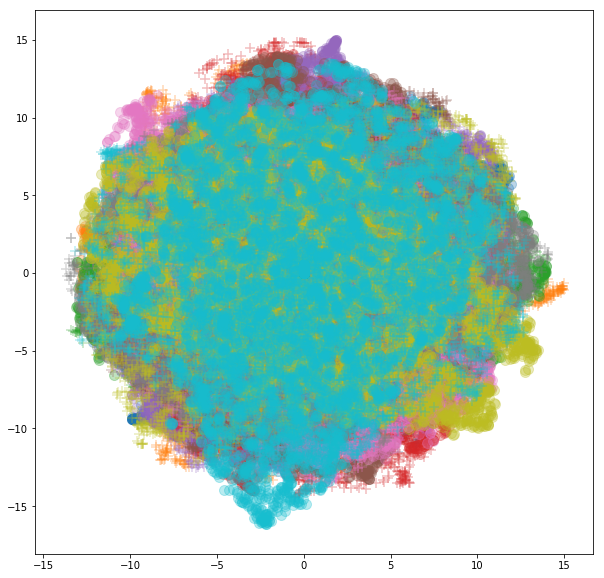

In [24]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 980 samples in 0.002s...
[t-SNE] Computed neighbors for 980 samples in 0.145s...
[t-SNE] Computed conditional probabilities for sample 980 / 980
[t-SNE] Mean sigma: 0.326142
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.682892
[t-SNE] Error after 300 iterations: 1.154119
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1744 samples in 0.004s...
[t-SNE] Computed neighbors for 1744 samples in 0.308s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1744
[t-SNE] Computed conditional probabilities for sample 1744 / 1744
[t-SNE] Mean sigma: 0.197735
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.763672
[t-SNE] Error after 300 iterations: 1.543100
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1135 samples in 0.002s...
[t-SNE] Computed neighbors for 1135 samples in 0.181s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1135
[t-SNE] Co

[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.135338
[t-SNE] Error after 300 iterations: 1.208119
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1595 samples in 0.003s...
[t-SNE] Computed neighbors for 1595 samples in 0.250s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1595
[t-SNE] Computed conditional probabilities for sample 1595 / 1595
[t-SNE] Mean sigma: 0.147589
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.939720
[t-SNE] Error after 300 iterations: 1.348160


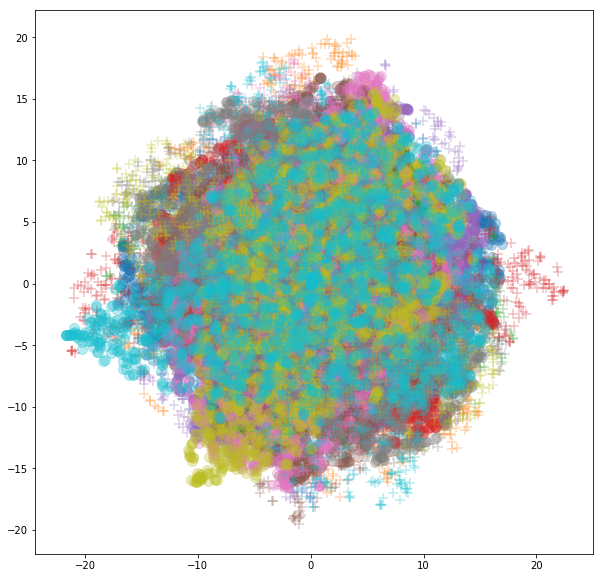

In [25]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model, domain='primary')
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model, domain='helper')


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)

### Conducting the same experiments for 'USPS'

In [26]:
# raw test data, seperate for both the primary and helper class
train_dataset_primary = loadDataset('MNIST', classes, instances,'train')
train_dataset_helper = loadDataset('USPS', classes, instances, 'train' )

# raw test data, seperate for both the primary and helper class
test_dataset_primary = loadDataset('MNIST', classes, instances,'test')
test_dataset_helper = loadDataset('USPS', classes, instances, 'test' )


primay_train_loader = torch.utils.data.DataLoader(train_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_train_loader = torch.utils.data.DataLoader(train_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

# raw test data, seperate for both the primary and helper class
primay_test_loader = torch.utils.data.DataLoader(test_dataset_primary, batch_size=batch_size, shuffle=True, **kwargs)
helper_test_loader = torch.utils.data.DataLoader(test_dataset_helper, batch_size=batch_size, shuffle=True, **kwargs)

triplet_train_dataset=TripletCD(train_dataset_primary, train_dataset_helper)
triplet_test_dataset=TripletCD(test_dataset_primary, test_dataset_helper)


triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [27]:
margin = 1.
embedding_net_primary = LeNet(1)
embedding_net_helper = LeNet(1)

model = TripletNet(embedding_net_primary, embedding_net_helper)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [28]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/50000 (0%)]	Loss: 0.999107
Train: [12800/50000 (26%)]	Loss: 0.468992
Train: [25600/50000 (51%)]	Loss: 0.167225
Train: [38400/50000 (77%)]	Loss: 0.097514
Epoch: 1/20. Train set: Average loss: 0.2050
Epoch: 1/20. Validation set: Average loss: 0.0722
Train: [0/50000 (0%)]	Loss: 0.133319
Train: [12800/50000 (26%)]	Loss: 0.051968
Train: [25600/50000 (51%)]	Loss: 0.039034
Train: [38400/50000 (77%)]	Loss: 0.040034
Epoch: 2/20. Train set: Average loss: 0.0414
Epoch: 2/20. Validation set: Average loss: 0.0341
Train: [0/50000 (0%)]	Loss: 0.022475
Train: [12800/50000 (26%)]	Loss: 0.031322
Train: [25600/50000 (51%)]	Loss: 0.027062
Train: [38400/50000 (77%)]	Loss: 0.024709
Epoch: 3/20. Train set: Average loss: 0.0261
Epoch: 3/20. Validation set: Average loss: 0.0223
Train: [0/50000 (0%)]	Loss: 0.000000
Train: [12800/50000 (26%)]	Loss: 0.020528
Train: [25600/50000 (51%)]	Loss: 0.020299
Train: [38400/50000 (77%)]	Loss: 0.021606
Epoch: 4/20. Train set: Average loss: 0.0203
Epoch: 4/20. Valid

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.013s...
[t-SNE] Computed neighbors for 5000 samples in 2.530s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.301920
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.888695
[t-SNE] Error after 300 iterations: 2.453434
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 767 samples in 0.001s...
[t-SNE] Computed neighbors for 767 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 767 / 767
[t-SNE] Mean sigma: 0.107583
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.405407
[t-SNE] Error after 300 iterations: 0.995349
[t-SNE] Computing 12

[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.827911
[t-SNE] Error after 300 iterations: 2.386295
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 377 samples in 0.001s...
[t-SNE] Computed neighbors for 377 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 377 / 377
[t-SNE] Mean sigma: 0.122748
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.375679
[t-SNE] Error after 300 iterations: 0.835060
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.025s...
[t-SNE] Computed neighbors for 5000 samples in 2.310s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.274486
[t-SNE] KL divergenc

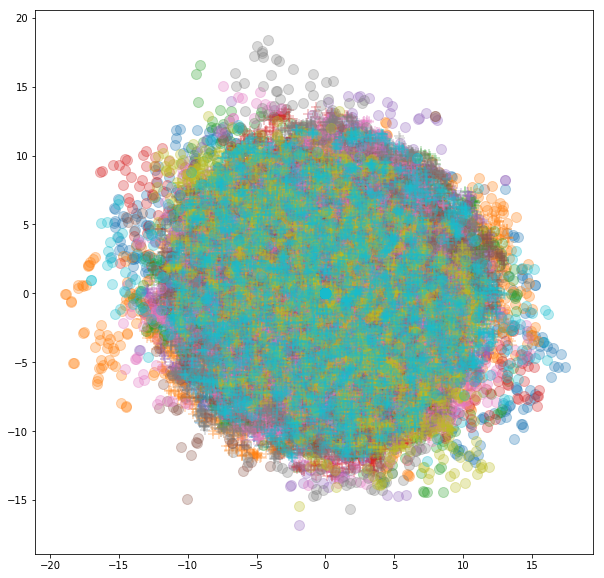

In [29]:
primary_train_embeddings, primary_train_labels = extract_embeddings(primay_train_loader, model, domain='primary')
helper_train_embeddings, helper_train_labels = extract_embeddings(helper_train_loader, model, domain='helper')


plot_embeddings(primary_train_embeddings, primary_train_labels, helper_train_embeddings, helper_train_labels)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 980 samples in 0.002s...
[t-SNE] Computed neighbors for 980 samples in 0.146s...
[t-SNE] Computed conditional probabilities for sample 980 / 980
[t-SNE] Mean sigma: 0.403062
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.117523
[t-SNE] Error after 300 iterations: 1.332846
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 786 samples in 0.001s...
[t-SNE] Computed neighbors for 786 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 786 / 786
[t-SNE] Mean sigma: 0.108336
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.413586
[t-SNE] Error after 300 iterations: 1.006660
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1135 samples in 0.002s...
[t-SNE] Computed neighbors for 1135 samples in 0.176s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1135
[t-SNE] Computed conditional probabilities for sample 1135 / 1135
[t-SNE] Mean s

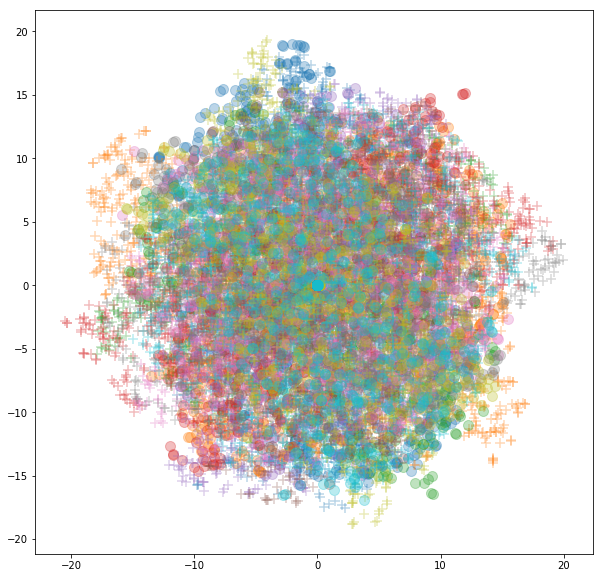

In [30]:
primary_test_embeddings, primary_test_labels = extract_embeddings(primay_test_loader, model, domain='primary')
helper_test_embeddings, helper_test_labels = extract_embeddings(helper_test_loader, model, domain='helper')


plot_embeddings(primary_test_embeddings, primary_test_labels, helper_test_embeddings, helper_test_labels)